In [247]:
from ews.models import BathingSpot
from django_pandas.io import read_frame
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from shapely.geometry import shape, Point
import plotly.express as px
import statsmodels


In [545]:
model = PredictionModel.objects.get(name = "Random Forest model")

In [546]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: testmodel>, <PredictionModel: Random Forest model>, <PredictionModel: Random Forest Marne>, <PredictionModel: Model Pont d'Iena>, <PredictionModel: Pont d'iena_rg (rain/flow)>]>

In [547]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: testmodel>, <PredictionModel: Random Forest model>, <PredictionModel: Random Forest Marne>, <PredictionModel: Model Pont d'Iena>, <PredictionModel: Pont d'iena_rg (rain/flow)>]>

In [548]:
areas = read_frame(model.area.all())

In [549]:
areavars = []
for index1, row1 in areas.iterrows():
    df = read_frame(Site.objects.filter(feature_type = FeatureType.objects.get(name=row1["feature_type"])))
    polygon = shape(row1["geom"])
    select = []
    
    for index2, row2 in df.iterrows():
        select.append(polygon.contains(shape(row2['geom'])))
    data = read_frame(FeatureData.objects.filter(site__in = df[select]['id']), index_col = "date")
    data["area"] = row1["name"]
    data["feature_type"] = row1["feature_type"]
    areavars.append(data)

In [550]:
lagvars = []

for i in range(len(areavars)):
    ft = areavars[i].area.unique()
    d = areavars[i].pivot(columns = 'site', values = 'value')
    if len(d.columns) > 1:
        d = pd.DataFrame(d.mean(axis = 1, skipna = True))
    for j in [1, 2, 3, 4, 5]:
        df = pd.DataFrame()
        df[ft + '_shift_'+ str(j)] = d.rolling(window=j).mean().shift(1)
        lagvars.append(df)
        
res = pd.concat(lagvars, axis = 1)

<AxesSubplot:xlabel='date'>

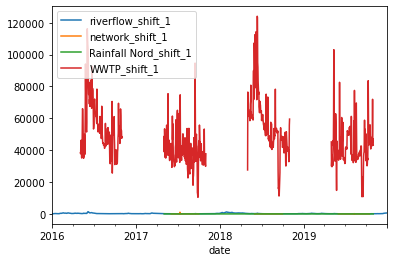

In [551]:
res.filter(regex='_shift_1').plot()

In [552]:
res = res[res.index.month.isin([ 6, 7, 8, 9])].reset_index()

In [553]:
FIB = read_frame(FeatureData.objects.filter(site = model.site.all()[0]))

In [554]:
FIB["date"] = FIB.date.round("D")

In [555]:
d = FIB.merge(res, on= "date")

In [556]:
D = d.dropna()

In [557]:
y = np.log10(D["value"])

In [558]:
X = D.drop(["date", "value", "id", "site"], axis = 1)

In [559]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [560]:
grid = {'n_estimators':[100], 'max_depth': np.linspace(10, 15, 6), 'max_features': [4,6,8]} 


In [561]:

from sklearn.model_selection import GridSearchCV, train_test_split


# Instantiate the ElasticNet regressor: elastic_net
rf = RandomForestRegressor()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(rf, param_grid=grid, cv = 5)

# Fit it to the training data

gm_cv.fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators = gm_cv.best_params_["n_estimators"],
                          max_depth = gm_cv.best_params_["max_depth"],
                          max_features = gm_cv.best_params_["max_features"])
rf.fit(X_train, y_train)


# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
y_pred1 = rf.predict(X_test)


r2 = gm_cv.score(X_test, y_test)
r2_in = gm_cv.score(X_train, y_train)

mse = mean_squared_error(y_test, y_pred)
mse_in = mean_squared_error(y_train, gm_cv.predict(X_train))

print(str("OUT OF SAMPLE METRICS:"))
print("Tuned  RandomForest R squared: {}".format(r2))
print("Tuned RandomForestt MSE: {}".format(mse))
print('---------------------------')
print("IN SAMPLE METRICS:")
print("Tuned  RandomForest R squared: {}".format(r2_in))
print("Tuned RandomForestt MSE: {}".format(mse))



OUT OF SAMPLE METRICS:
Tuned  RandomForest R squared: 0.28705763689928854
Tuned RandomForestt MSE: 0.2928771113678828
---------------------------
IN SAMPLE METRICS:
Tuned  RandomForest R squared: 0.8998048570189183
Tuned RandomForestt MSE: 0.2928771113678828


In [562]:
gm_cv.best_params_

{'max_depth': 11.0, 'max_features': 8, 'n_estimators': 100}

In [563]:
df_test = pd.DataFrame({'meas': y_test, 'pred': gm_cv.predict(X_test), 'split': 'out of sample'})
df_train = pd.DataFrame({'meas': y_train, 'pred': gm_cv.predict(X_train), 'split': 'in sample'})
df = pd.concat([df_test, df_train])
                        


In [564]:
fig = px.scatter(df, x = "meas", y = "pred", color = "split", 
                 color_discrete_sequence=['#212c52','#75c3ff'])

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)

fig.show()

In [565]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_df = importances_sorted.reset_index()
importances_df.columns = ["feature", "importance"]

In [566]:
# Draw a horizontal barplot of importances_sorted
import plotly.express as px


fig = px.bar(importances_df, y="feature", x="importance", orientation='h'    )

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Feature importance of Random Forest model'}
    #markercolor = "#212c52"
  
)
fig.update_traces(marker_color='#75c3ff', marker_line_color='#75c3ff',
                  marker_line_width=1.5, opacity=1)

fig.show()


## Calculating prediction intervals

In [567]:
from sklearn.ensemble import GradientBoostingRegressor# Set lower and upper quantile

LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95# Each model has to be separate

lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")

upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [609]:
import scipy.stats
import decimal

weights = scipy.stats.norm(3, 1).pdf(y_train.apply(float))

In [610]:
weights

array([0.38988488, 0.32697131, 0.38997369, 0.39854677, 0.12111538,
       0.30178126, 0.3746215 , 0.31925736, 0.38641671, 0.39788116,
       0.39892844, 0.33876337, 0.36626669, 0.37693753, 0.38482722,
       0.35572657, 0.26534503, 0.37000091, 0.33384746, 0.39770453,
       0.34590252, 0.39347459, 0.12111538, 0.12111538, 0.12111538,
       0.38901161, 0.26954472, 0.39475912, 0.36016523, 0.38812116,
       0.38988488, 0.36694159, 0.39874046, 0.39658357, 0.39584072,
       0.39331902, 0.26114378, 0.39845937, 0.37800226, 0.37533515,
       0.38420342, 0.37603511, 0.37693753, 0.25253502, 0.3172449 ,
       0.33626415, 0.39894045, 0.12111538, 0.14087247, 0.16738706,
       0.38054545, 0.39486558, 0.39490283, 0.38420342, 0.39221532,
       0.34840486, 0.39462489, 0.33315936, 0.39890022, 0.39286463,
       0.37918081, 0.38176744, 0.18867539, 0.38886431, 0.12111538,
       0.3863197 , 0.29960129, 0.35103185, 0.36743927, 0.33384746,
       0.39558481, 0.39584072, 0.12111538, 0.39735208, 0.38014

In [611]:
px.scatter(x = y_train, y = weights)

In [612]:
# Fit models
lower_model.fit(X_train, y_train, sample_weight =weights)
mid_model.fit(X_train, y_train, sample_weight =weights)
upper_model.fit(X_train, y_train, sample_weight =weights)# Record actual values on test set

predictions = pd.DataFrame(y_test)# Predict

predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [613]:
predictions["Nummer"] = range(len(predictions))

In [614]:
import plotly.graph_objects as go

upper_bound = go.Scatter(name="Oberes Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["upper"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"),
fillcolor="rgba(68, 68, 68, 1)")#, fill="tonexty")

mean = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["mid"],
marker = dict(color = "rgb(0, 86, 110)"),
mode="lines",
line=dict(width=1, color= "rgb(0, 86, 110)"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")

measurements = go.Scatter(name="Vorhergesagter Mittelwert",
x= predictions["Nummer"],
y=predictions["value"],
marker = dict(color = "red"),
mode="markers",
line=dict(width=1, color= "red"),
fillcolor="rgba(68, 68, 68, 0.1)")#, fill="tonexty")



lower_bound = go.Scatter(name="Unteres Vorhersageintervall",
x= predictions["Nummer"],
y=predictions["lower"],
mode="lines",
line=dict(width=0.5, color="rgba(68, 68, 68, 1)"))

data = [lower_bound, mean, upper_bound, measurements]

layout=go.Layout(title='Vorhergesagte E.coli Konzentration seit Beginn der Badesaison 2020',
yaxis=dict(title="E.coli lg [MPN/100ML), showlegend = True"))

fig=go.Figure(data=data, layout = layout)
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()
    

In [618]:
fig = px.scatter(predictions, x = "value", y = "mid", 
                 color_discrete_sequence=['#212c52'], trendline = 'OLS')

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markersize= 12,
  )
fig.update_layout(legend=dict(
    yanchor="top",
    title=None,
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_traces(marker_size = 10)#['#75c3ff', "red"],#, marker_line_color='#212c52',
 #                 marker_line_width=1.5, opacity=1)

fig.show()